In [1]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from random import shuffle,randint
import pandas as pd
import h5py
from itertools import product
import matplotlib.pyplot as plt


import sys
sys.path.insert(0,"..")
import helper
import MyMagics

# fuer progress widget https://ipywidgets.readthedocs.io/en/stable/user_install.html
from tqdm import tqdm_notebook

tile_size = 32 # block_size
PROJECTNAME = "image-filtering"
hdf5_file = f'{PROJECTNAME}-data({tile_size}).hdf5'
model_file = 'model2.hdf5'
folder = Path("./training_data2")

load_hdf5 = False
save_data = False
load_saved_model = True
train_model = True
save_model = True

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from io import BytesIO
# convert image to jpeg without saving it on disk
def im2jpg(im:Image, quality:int)-> Image:
    with BytesIO() as fp:
        im.save(fp,format="jpeg",quality=quality)
        im_jpg = Image.open(fp)
        im_jpg.load()
    return im_jpg

## Load Images 

In [29]:
if not load_hdf5 or not Path(hdf5_file).exists():
    xy_list = [] 
    filelist = [x for x in folder.iterdir() if x.is_file()]
    for p in tqdm_notebook(filelist):
        im = Image.open(p).convert('RGB') 
        #im_jpg = Image.open(j).convert('RGB')
        im_jpg = im2jpg(im,randint(40,80))
        
        im = np.asarray(im,'float32')
        im_jpg = np.asarray(im_jpg,'float32')
        
        im/=255 # no idea if inplace is really more efficient
        im_jpg/=255
        
        (h,w,_) = im.shape
        (h,w) = (h//tile_size,w//tile_size)
        

        for x,y in product(range(w),range(h)):
            tile = im[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size,].copy()
            tile_jpg = im_jpg[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size,].copy()
            

            mse = ((tile-tile_jpg)**2).mean()
            if mse > 0.0001: # 0.0005
                xy_list.append((tile_jpg,tile))

                
    splt = int(len(xy_list)*0.9)
    print(len(xy_list))
    
        
    shuffle(xy_list)
    
    x_list,y_list = zip(*xy_list)
    
    
    x_train = np.array(x_list[:splt])   
    y_train = np.array(y_list[:splt])
    x_test  = np.array(x_list[splt:])   
    y_test  = np.array(y_list[splt:])
    
    
    del xy_list
    del x_list
    del y_list
    
    
    if save_data:
        with h5py.File(hdf5_file,'w') as f:
            f.create_dataset('x_train', data=x_train, compression='lzf')
            f.create_dataset('y_train', data=y_train, compression='lzf')
            f.create_dataset('x_test', data=x_test, compression='lzf')
            f.create_dataset('y_test', data=y_test, compression='lzf')  
    
else:
    print("loading cached data")
    with h5py.File(hdf5_file,'r')as f:
        x_train = f['x_train'].value
        y_train = f['y_train'].value
        
        x_test = f['x_test'].value
        y_test = f['y_test'].value
    
print(f"training data loaded")

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))


28058
training data loaded


In [62]:
%%skip
plt.figure(figsize=(18,18))
for i in range(0,64,2):
    plt.subplot(8,8,i+1)
    plt.imshow(y_train[i])
    plt.subplot(8,8,i+2)
    plt.imshow(x_train[i])
plt.show()

skipping cell!


## Import Keras and reduce tf memory allocation

In [5]:
import keras
from keras.layers import Conv2D,Deconv2D
from keras.layers import Input,Add
from keras.models import load_model,Model
from keras.callbacks import EarlyStopping,TensorBoard
from keras import backend as K

Using TensorFlow backend.


In [6]:
if K.backend() == 'tensorflow':
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    K.tensorflow_backend.set_session(tf.Session(config=config))

In [7]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

## Create Model ( or load it if a saved model exists )

In [8]:
if load_saved_model:
    print("loading saved model")
    model = load_model(model_file,custom_objects={'PSNRLoss':PSNRLoss})
else:  
    input_img = Input(shape=(tile_size,tile_size,3))
    
    conv1 = Conv2D(64, (3, 3), activation='relu',padding='same')(input_img)
    conv2 = Conv2D(64, (3, 3), activation='relu',padding='same')(conv1)
    deconv1 = Deconv2D(64, (3, 3),activation='relu',padding='same')(conv2)
    merge1 = Add()([deconv1,conv2])
    deconv2 = Deconv2D(64, (3, 3),activation='relu',padding='same')(merge1)
    merge2 = Add()([deconv2,conv1])
    
    out = Conv2D(3, (5, 5), activation='linear', padding='same')(merge2)
    
    
    model = Model(inputs=input_img, outputs=out)  

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(lr=1e-3),
                  metrics=[PSNRLoss])
model.summary()

loading saved model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 32, 32, 64)   36928       conv2d_2[0][0]                   
_________________________________________________________________________________________

## train model

In [9]:
%%time

if train_model:
    early_stopping = EarlyStopping(monitor='loss', patience=5)

    hist =  model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    shuffle=True,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping],
                    verbose=2)
    if save_model:
        model.save(model_file)

Train on 17702 samples, validate on 1967 samples
Epoch 1/50
 - 9s - loss: 5.2406e-04 - PSNRLoss: 32.9222 - val_loss: 5.7225e-04 - val_PSNRLoss: 32.4868
Epoch 2/50
 - 8s - loss: 4.6426e-04 - PSNRLoss: 33.4410 - val_loss: 4.3513e-04 - val_PSNRLoss: 33.7038
Epoch 3/50
 - 8s - loss: 4.4702e-04 - PSNRLoss: 33.5980 - val_loss: 4.5564e-04 - val_PSNRLoss: 33.4918
Epoch 4/50
 - 8s - loss: 4.3029e-04 - PSNRLoss: 33.7580 - val_loss: 4.1870e-04 - val_PSNRLoss: 33.8713
Epoch 5/50
 - 8s - loss: 4.1734e-04 - PSNRLoss: 33.8959 - val_loss: 4.1851e-04 - val_PSNRLoss: 33.8703
Epoch 6/50
 - 8s - loss: 4.1638e-04 - PSNRLoss: 33.9040 - val_loss: 5.4058e-04 - val_PSNRLoss: 32.7249
Epoch 7/50
 - 8s - loss: 4.1018e-04 - PSNRLoss: 33.9784 - val_loss: 4.2097e-04 - val_PSNRLoss: 33.8378
Epoch 8/50
 - 8s - loss: 4.0111e-04 - PSNRLoss: 34.0705 - val_loss: 3.9724e-04 - val_PSNRLoss: 34.0997
Epoch 9/50
 - 8s - loss: 3.9737e-04 - PSNRLoss: 34.1101 - val_loss: 4.0049e-04 - val_PSNRLoss: 34.0615
Epoch 10/50
 - 8s - loss

## Plot loss and accuracy for all epochs

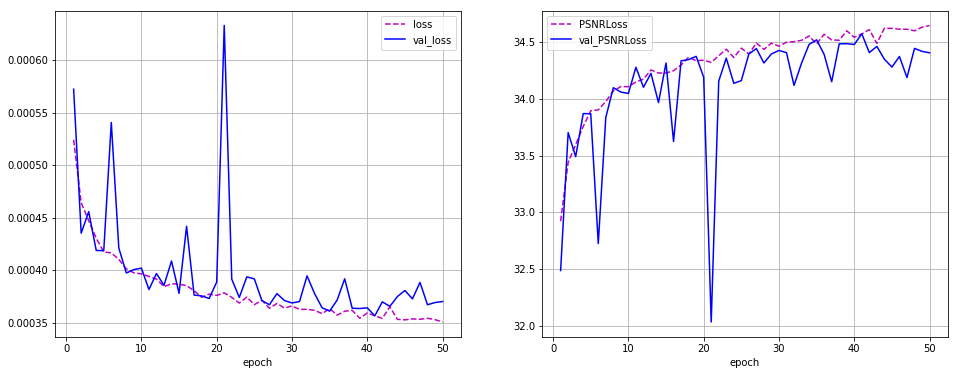

maximum PSNRLoss: 34.6489
minimum loss: 0.000351


In [10]:
if True:
    helper.plot_model(hist,size=(16,6))

    x = max(hist.history['PSNRLoss'])
    print(f"maximum PSNRLoss: {x:.4f}")
    x = min(hist.history['loss'])
    print(f"minimum loss: {x:f}")

## Show comparison between original,jpg and reconstructed image

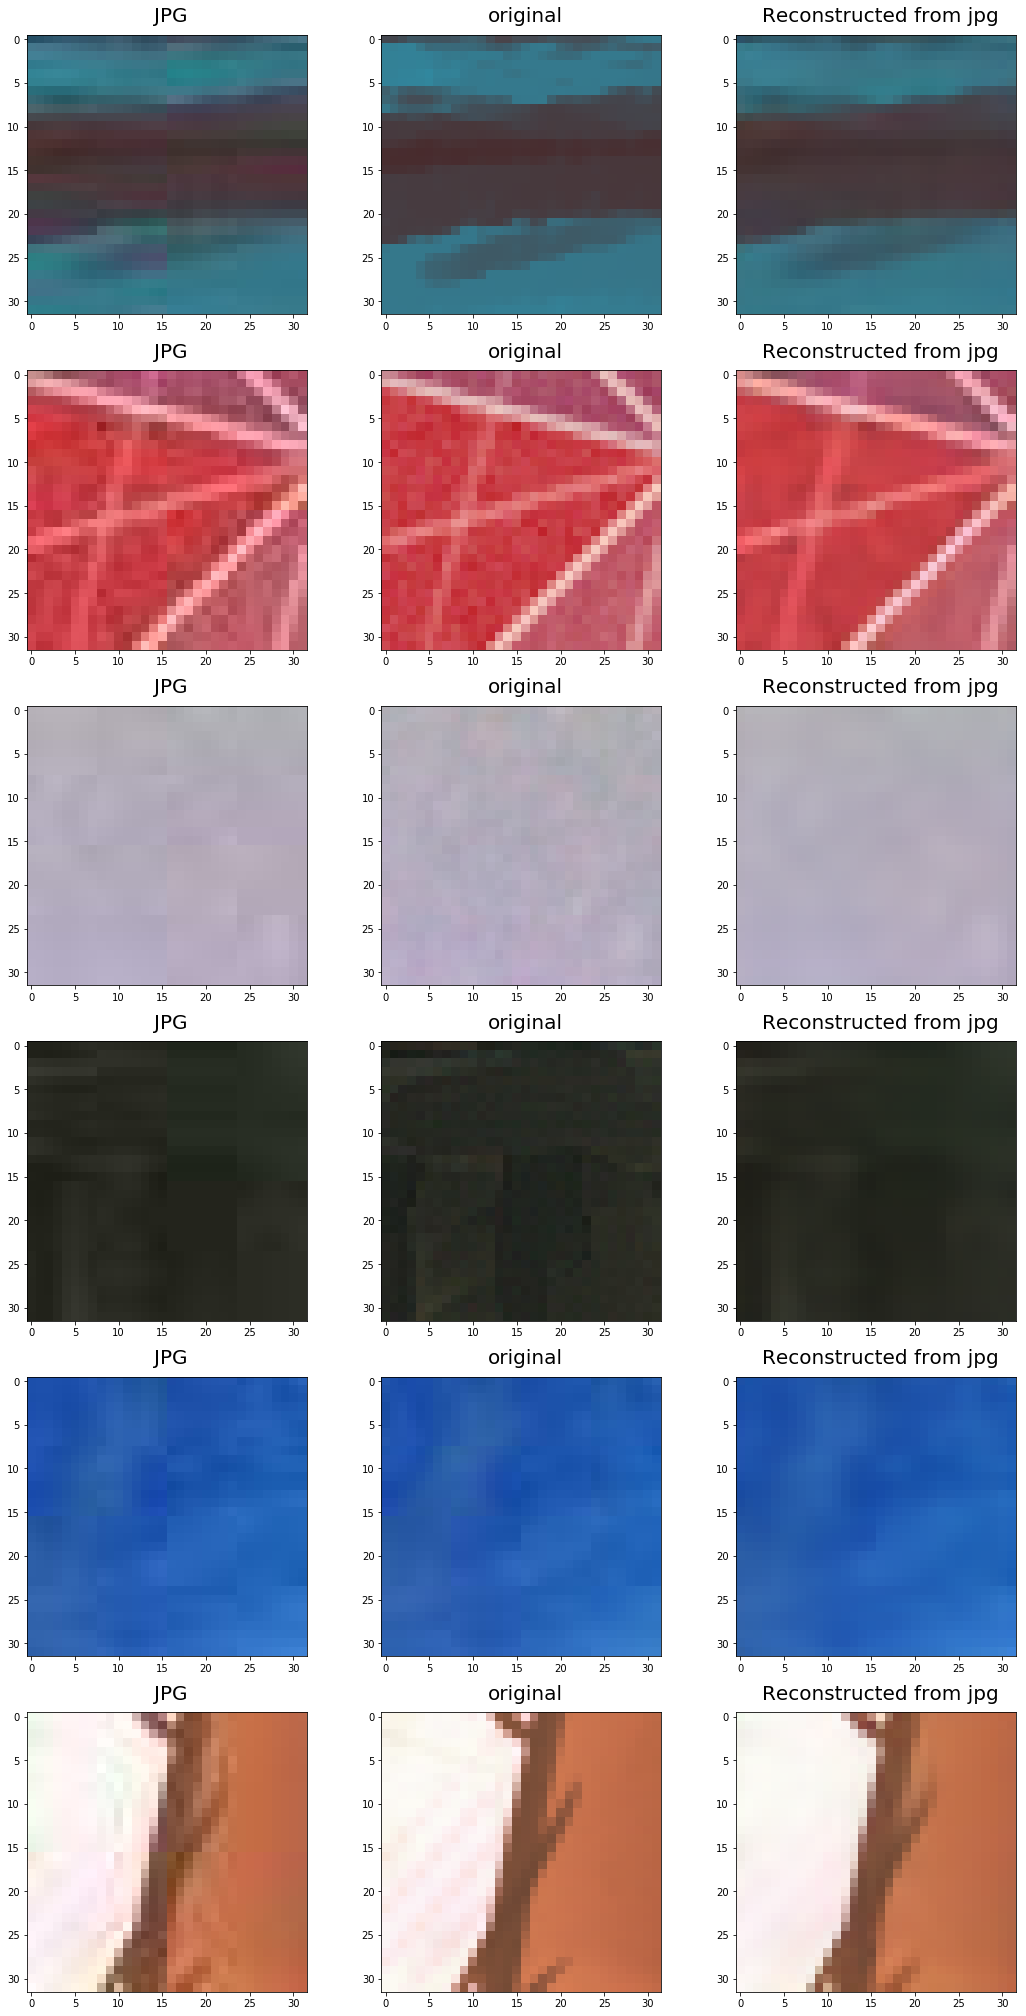

In [61]:

interpolation = "nearest"


rows = 6
cols = 3
plt.figure(figsize=(18,18/cols*rows))
for i in range(rows):
    idx = randint(0,x_test.shape[0]-1)
    decoded_img = model.predict(x_train[idx:idx+1],verbose=0)[0]
    decoded_img = np.clip(decoded_img,0,1)
    plt.subplot(rows,cols,1+i*cols)
    plt.imshow(x_train[idx],interpolation=interpolation)
    plt.text(tile_size/2,-2,"JPG",fontsize=20, horizontalalignment='center')
    
    plt.subplot(rows,cols,2+i*cols)
    plt.imshow(y_train[idx],interpolation=interpolation)
    plt.text(tile_size/2,-2,"original",fontsize=20, horizontalalignment='center')
    
    plt.subplot(rows,cols,3+i*cols)
    plt.imshow(decoded_img,interpolation=interpolation)
    plt.text(tile_size/2,-2,"Reconstructed from jpg",fontsize=20, horizontalalignment='center')
plt.show()

## Use the trained model on a full image

## CNN auf vollständiges Bild anwenden
Das Bild wird wie beim Training aufgeteilt, zuvor wird jedoch mit numpy.pad(...) ein rand hinzugefügt um auf 
ein vielfaches der TileSize zu kommen.
Beim aufteilen überlappen sich alle "Tiles" um p pixel, diese überlappung wird später beim zusammenfügen
weggelassen um ein nahtloses Bild zu erzeugen

In [ ]:
%%skip
#im = Image.open("0391.jpg")
from math import ceil
from itertools import product


p = 6 # overlap
ts = tile_size
ts2 = ts-p*2 # actual tile_size

im = np.asarray(Image.open("training_data/0391.jpg").convert('RGB')).astype('float32')/255

(h,w,_) = im.shape

#neue abemssungen des bildes berechnen um auf vielfaches von ts zu kommen
bh = ts2*ceil((h+p*2)/ts2)
bw = ts2*ceil((w+p*2)/ts2)
# links und oben nur overlap als rand und rechts und unten etwas mehr um auf vielfaches von ts zu kommen
im = np.pad(im,((p,p+bh-h),(p,p+bw-w),(0,0)),mode='reflect')

pred_im = np.zeros(im.shape,dtype="uint8")

tiles = np.zeros(((bw//ts2+1)*(bh//ts2+1),ts,ts,3),dtype="float32")

# bild in 32*32 große tiles aufteilen mit überlappung p
for i,(x,y) in enumerate(product(range(0,bw,ts2),range(0,bh,ts2))):
    tiles[i] = im[y:(y+ts), x:(x+ts),]

#tiles durch cnn schicken
pred_tiles = model.predict(tiles)

# array für umwandlung in bild vorbereiten
pred_tiles = np.clip(pred_tiles*255,0,255).astype("uint8")

# bild wieder zusammensetzen ohne überlappende bereiche
for i,(x,y) in enumerate(product(range(p,bw,ts2),range(p,bh,ts2))):
    pred_im[y:(y+ts2), x:(x+ts2),] = pred_tiles[i,p:-p,p:-p,]

# "padding" entfernen und array zu bild machen
pred_im = Image.fromarray(pred_im[p:h+p, p:w+p,])
pred_im.save("out.png")